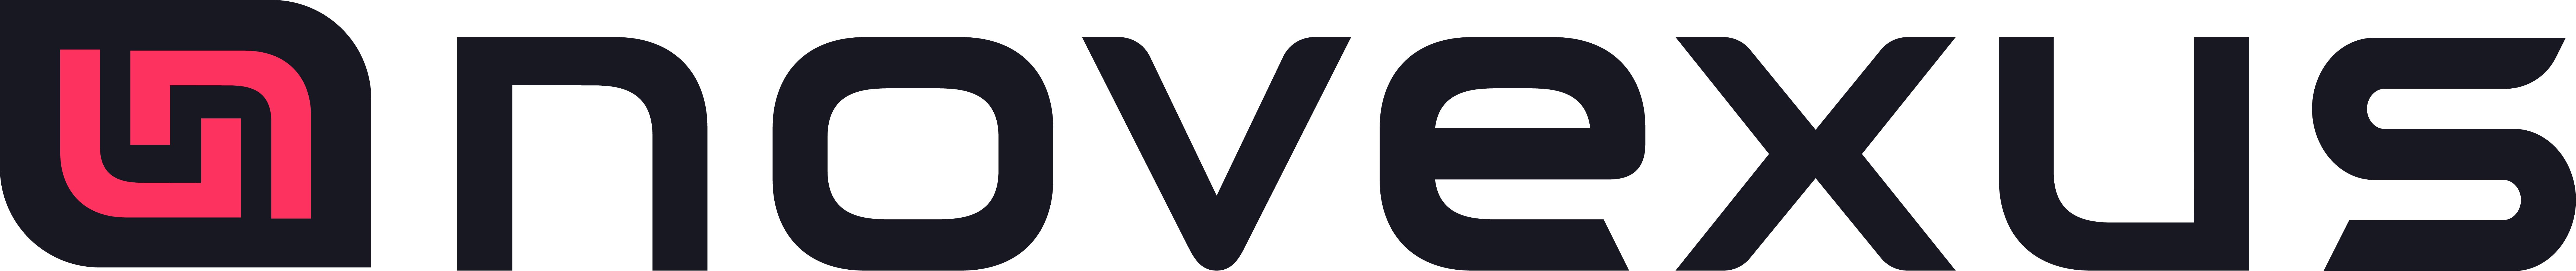

---

# Sobre o desafio

Neste desafio, suponhamos que tenhamos sido recrutados como cientistas de dados pela empresa de telecomunicações **Novexus**. Durante nossa reunião introdutória com os responsáveis da equipe de vendas da organização, foi destacada a significância da redução da **Taxa de Churn**, também conhecida como **Taxa de Evasão de Clientes**.

Com base em nossa experiência, propomos como etapa inicial a identificação dos clientes com maior propensão a abandonar os serviços da Novexus. Isso gerou um consenso entre todos os membros da equipe sobre a importância de investigar minuciosamente as características dos clientes e dos planos utilizados, a fim de **CLASSIFICAR** esses indivíduos como possíveis candidatos à desistência ou como clientes prováveis de permanecerem.

Durante a primeira semana, nosso foco será na tarefa de limpeza e análise exploratória dos dados.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Informações gerais do Conjunto de dados</h1>
</div>

## Acesso aos dados, normalização e visualização rápida do cabeçalho

In [1]:
import pandas as pd
import requests
import json

url = 'https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json'
dados = requests.get(url).json()
dados = pd.json_normalize(dados)

In [2]:
dados.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Leitura do dicionário dos dados

In [3]:
url_info = 'https://challenge-data-science-3ed.s3.amazonaws.com/dicionario.md'
print(requests.get(url_info).content.decode('utf-8'))

#### Dicionário de dados

* `customerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa 
* `gender`: gênero (masculino e feminino) 
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos 
* `Partner`:  se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `tenure`:  meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico 
* `MultipleLines`: assisnatura de mais de uma linha de telefone 
* `InternetService`: assinatura de um provedor internet 
* `OnlineSecurity`: assinatura adicional de segurança online 
* `OnlineBackup`: assinatura adicional de backup online 
* `DeviceProtection`: assinatura adicional de proteção no dispositivo 
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo 
* `StreamingMovies`: assinatura de streaming de filmes 
* `Contract`: tipo de co

## Valores únicos e análise da tipagem dos dados

In [4]:
def valores_unicos_e_tipagem(dados):
    for col in dados.columns:
        if dados[col].nunique() > 4:
            print(
                f'# Coluna {dados[col].dtypes}: {col} - Existem {dados[col].nunique()}/{len(dados[col])} valores únicos'
            )
        else:
            print(f'# Coluna {dados[col].dtypes}: {col}', dados[col].unique())


valores_unicos_e_tipagem(dados)

# Coluna object: customerID - Existem 7267/7267 valores únicos
# Coluna object: Churn ['No' 'Yes' '']
# Coluna object: customer.gender ['Female' 'Male']
# Coluna int64: customer.SeniorCitizen [0 1]
# Coluna object: customer.Partner ['Yes' 'No']
# Coluna object: customer.Dependents ['Yes' 'No']
# Coluna int64: customer.tenure - Existem 73/7267 valores únicos
# Coluna object: phone.PhoneService ['Yes' 'No']
# Coluna object: phone.MultipleLines ['No' 'Yes' 'No phone service']
# Coluna object: internet.InternetService ['DSL' 'Fiber optic' 'No']
# Coluna object: internet.OnlineSecurity ['No' 'Yes' 'No internet service']
# Coluna object: internet.OnlineBackup ['Yes' 'No' 'No internet service']
# Coluna object: internet.DeviceProtection ['No' 'Yes' 'No internet service']
# Coluna object: internet.TechSupport ['Yes' 'No' 'No internet service']
# Coluna object: internet.StreamingTV ['Yes' 'No' 'No internet service']
# Coluna object: internet.StreamingMovies ['No' 'Yes' 'No internet service']
# 

Algumas observações:

- A coluna `customerID` contém 7267 valores únicos, o que sugere que cada registro representa um cliente distinto.
- A coluna `Churn` possui alguns valores em branco.
- A coluna `Charges.Total` é sinalizada como tipo `object` (strings).

Vamos ver quantos destes dados são nulos:

In [5]:
n_faltantes = dados[dados['Churn'] == ''].shape[0]
porcentagem_n_faltantes = round((n_faltantes / len(dados)) * 100, 2)

print(
    f'Existem {n_faltantes} dados faltantes na coluna Churn. Isso representa {porcentagem_n_faltantes}% do total'
)

Existem 224 dados faltantes na coluna Churn. Isso representa 3.08% do total


Vamos analisar a coluna `Charges.Total` e transformá-la para valores numéricos:

In [6]:
list(dados['account.Charges.Total'].head())

['593.3', '542.4', '280.85', '1237.85', '267.4']

In [7]:
# Existem dados faltantes, por isso errors = 'coerce'
dados['account.Charges.Total'] = pd.to_numeric(dados['account.Charges.Total'],
                                               errors='coerce')

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

Quando convertemos a coluna `account.Charges.Total` de tipo 'object' para 'float64', observamos a presença de valores ausentes no conjunto de dados. É necessário tratar esses dados também.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1> Tratamento inicial das incosistências nos dados </h1>
</div>

Resolvendo o problema dos dados faltantes para a coluna `Churn`: excluindo essas instâncias!

In [9]:
dados_md1 = dados.copy().loc[~(dados['Churn'] == '')].reset_index(drop=True)

Vamos resolver o problema dos dados ausentes na coluna `Charges.Total` ao observar as informações disponíveis nas colunas que se referem ao tempo de uso e aos gastos do cliente:

- `customer.tenure`: representa a duração do contrato em meses.
- `account.Contract`: indica o tipo de contrato.
- `account.Charges.Monthly`: mostra o valor total de serviços utilizados pelo cliente mensalmente.
- `account.Charges.Total`: denota o gasto total do cliente.

In [10]:
dados_md1[dados_md1['account.Charges.Total'].isnull()][[
    'customer.tenure', 'account.Contract', 'account.Charges.Monthly',
    'account.Charges.Total'
]]

,customer.tenure,account.Contract,account.Charges.Monthly,account.Charges.Total
945,0,Two year,56.05,NaN
1731,0,Two year,20.00,NaN
1906,0,Two year,61.90,NaN
2025,0,One year,19.70,NaN
2176,0,Two year,20.25,NaN
2250,0,Two year,25.35,NaN
2855,0,Two year,73.35,NaN
3052,0,Two year,25.75,NaN
3118,0,Two year,52.55,NaN
4054,0,Two year,80.85,NaN


Vamos resolver a questão dos dados ausentes na coluna `account.Charges.Total` considerando as informações de `account.Contract` com duração de 1 ou 2 anos. Nessa abordagem, podemos estimar que o gasto total do cliente seja o produto dos valores totais dos serviços mensais (`account.Charges.Monthly`) com período contratual (12 ou 24 meses). Uma vez que os dados de `customer.tenure` (duração do contrato em meses) não estão disponíveis também (está como zero), podemos aproveitar as informações da coluna `account.Contract` para suprir essa lacuna.

In [11]:
indice_dados_faltantes = dados_md1[
    dados_md1['account.Charges.Total'].isnull()].index


def gasto_total(linha):
    if linha['account.Contract'] == 'Two year':
        linha['account.Charges.Total'] = linha['account.Charges.Monthly'] * 24
        linha['customer.tenure'] = 24
    else:
        linha['account.Charges.Total'] = linha['account.Charges.Monthly'] * 12
        linha['customer.tenure'] = 12
    return linha


dados_md2 = dados_md1.copy()
dados_md2.loc[indice_dados_faltantes] = dados_md2.loc[
    indice_dados_faltantes].apply(gasto_total, axis=1)

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1> Exploratory Data Analysis </h1>
</div>

## Paleta de cores e funções auxiliares

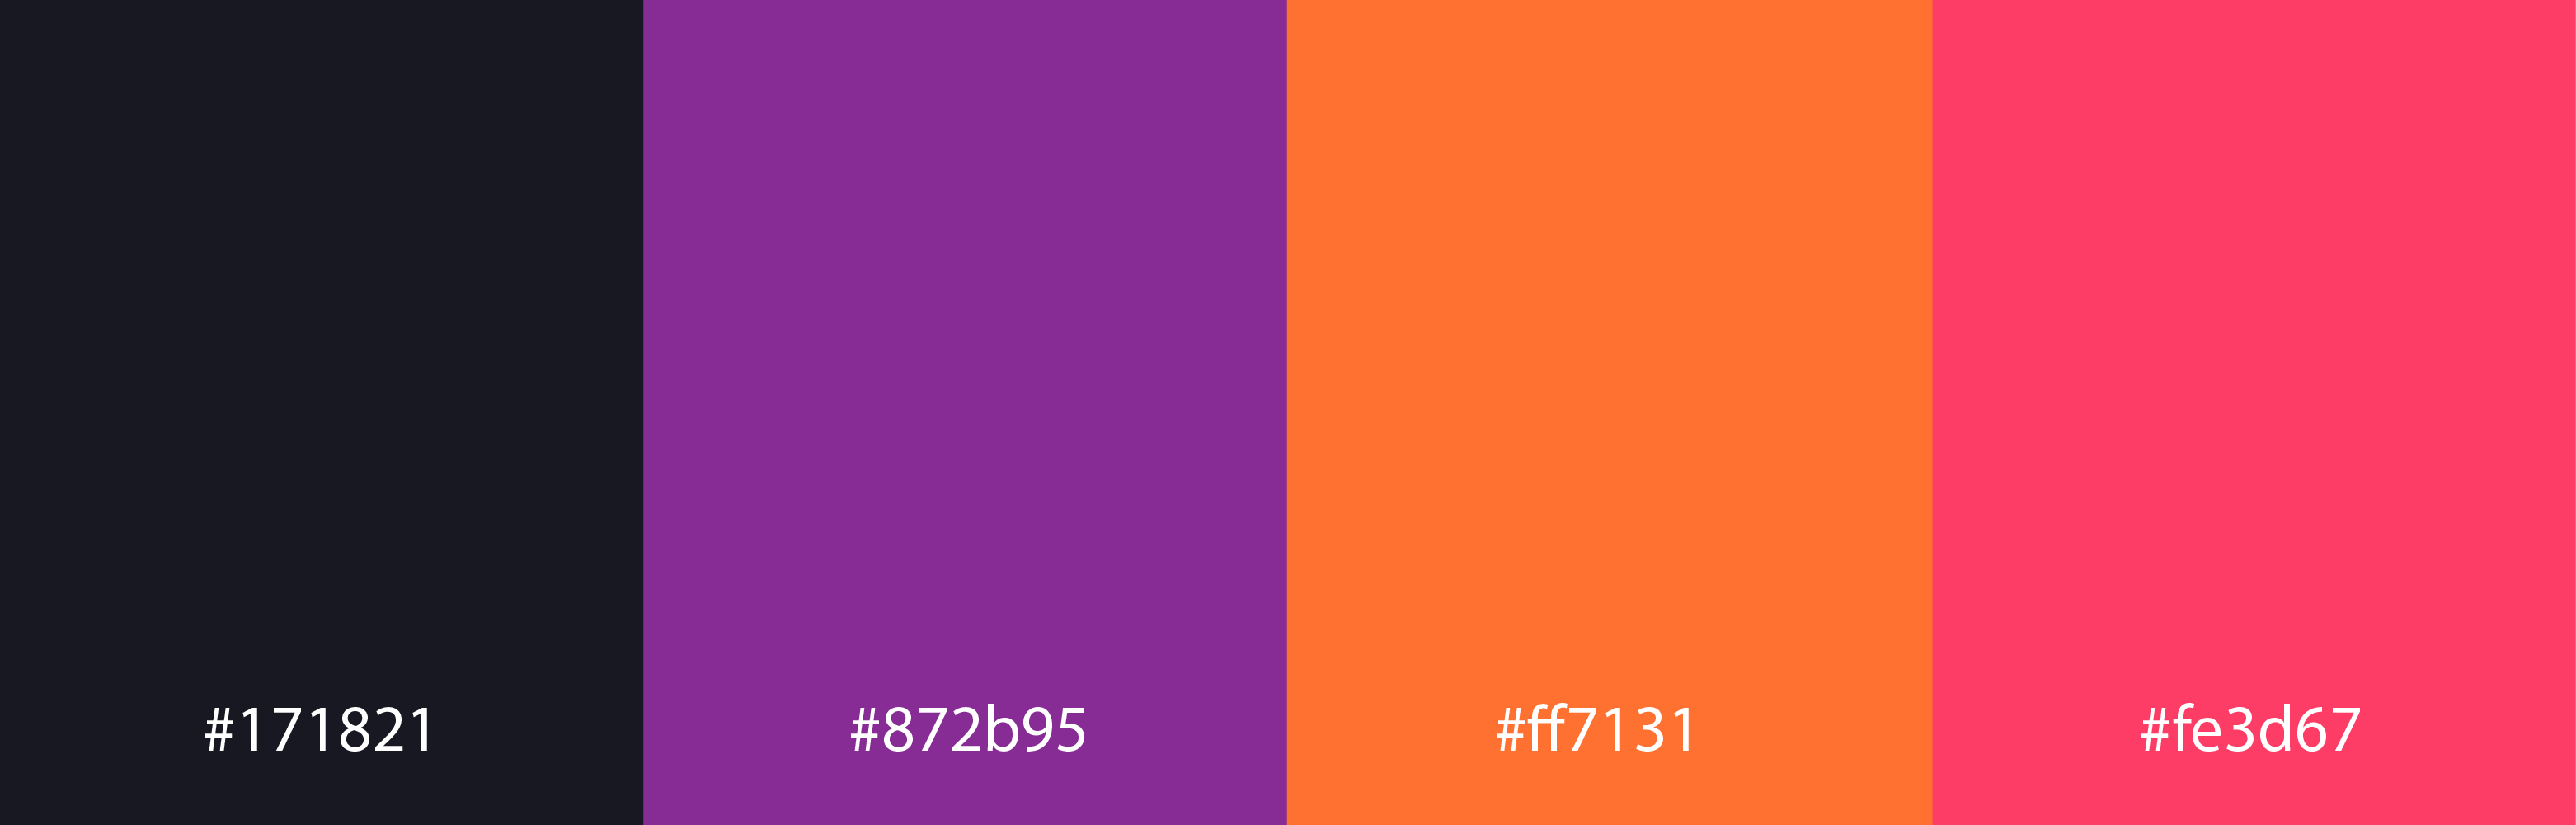

In [12]:
paleta = ['#171821', '#872b95', '#ff7131', '#fe3d67']

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

def plot_countplots(data, coluna_hue, grupos, figsize=(12, 8)):
    num_grupos = len(grupos)
    cols = 2
    linhas = int(np.ceil(num_grupos / cols))

    fig, axes = plt.subplots(nrows=linhas, ncols=cols, figsize=figsize)
    axes = axes.flatten()  # Transforma a matriz de eixos em uma matriz 1D

    for i, grupo in enumerate(grupos):
        if i < num_grupos:
            eixo = axes[i]  # Acessa o eixo diretamente da matriz 1D
            sns.countplot(x=grupo,
                          data=data,
                          hue=coluna_hue,
                          palette=paleta,
                          alpha=0.8,
                          ax=eixo)
            sns.despine(right=True, top=True)
            eixo.legend([], [], frameon=False)
            eixo.set_xlabel(grupo.split('.')[-1])
            eixo.set_ylabel('Frequência')

    # Remove quaisquer subplots vazios adicionais
    for i in range(num_grupos, linhas * cols):
        fig.delaxes(axes[i])

    # Cria uma legenda fora dos subplots
    handles, labels = eixo.get_legend_handles_labels()
    legenda = fig.legend(handles,
                         labels,
                         loc='upper center',
                         bbox_to_anchor=(0.5, 1.13),
                         ncol=2)
    legenda.set_title('Churn')

    plt.tight_layout()
    
def adicionar_estatisticas(ax, dados, metrica, texto_y, cor):
    valores_estatisticos = dados.groupby('Churn')[metrica].agg(['mean', 'median', 'min', 'max'])
    
    texto = f'Média: {valores_estatisticos["mean"][0]:.2f} | {valores_estatisticos["mean"][1]:.2f}\n'
    texto += f'Mediana: {valores_estatisticos["median"][0]:.2f} | {valores_estatisticos["median"][1]:.2f}\n'
    texto += f'Mínimo: {valores_estatisticos["min"][0]:.2f} | {valores_estatisticos["min"][1]:.2f}\n'
    texto += f'Máximo: {valores_estatisticos["max"][0]:.2f} | {valores_estatisticos["max"][1]:.2f}'
    
    ax.text(0.5, texto_y, texto, transform=ax.transAxes, fontsize=12, color=cor, ha='center')

## Visualização da variável target (Churn)

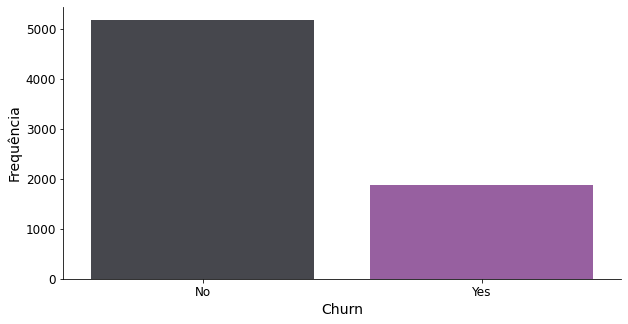

In [14]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Churn', data=dados_md2, palette=paleta, alpha=.8)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.show()

In [15]:
dados_md2['Churn'].value_counts(normalize=True).round(4) * 100

No     73.46
Yes    26.54
Name: Churn, dtype: float64

Os dados estão desequilibrados, com uma grande maioria de clientes (cerca de 73.46%) que não cancelaram o serviço, enquanto apenas 26.54% cancelaram. Isso significa que qualquer previsão feita com esses dados provavelmente favorecerá os clientes que não cancelaram o serviço. Além disso, qualquer representação visual dos dados também destacará esse desequilíbrio.

## Features categóricas versus Churn

### Grupo 1: Features com informações sobre os clientes

In [16]:
grupo_1 = dados_md2.filter(like='customer').columns.tolist()[1:-1]

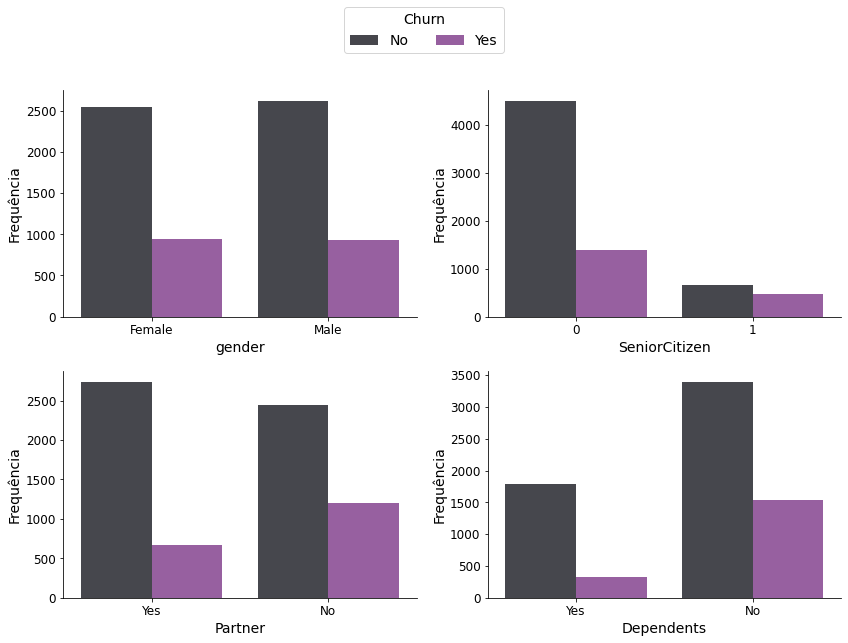

In [17]:
plot_countplots(dados_md1, 'Churn', grupo_1)

A taxa de cancelamento de clientes é praticamente igual tanto para homens quanto para mulheres. Além disso, o número de clientes idosos é relativamente baixo. Os clientes que vivem com um parceiro têm menos probabilidade de cancelar em comparação com aqueles que não têm parceiros. Da mesma forma, as taxas de cancelamento são mais altas entre os clientes que não têm dependentes.

### Grupo 2: Features com serviços telefônicos

In [18]:
grupo_2 = dados_md2.filter(like='phone').columns.tolist()

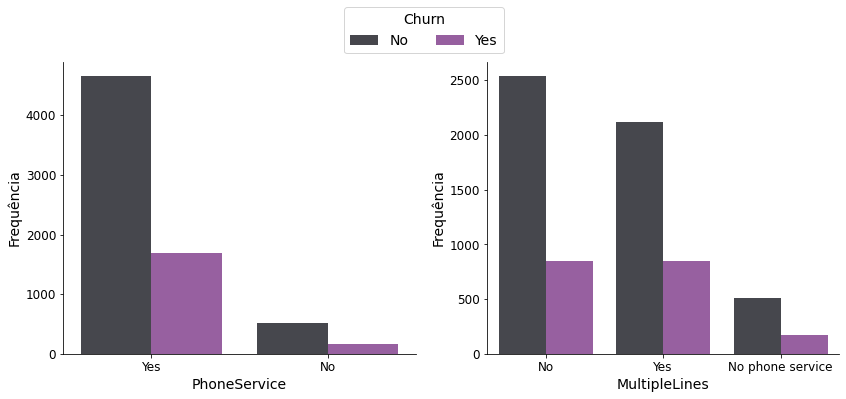

In [19]:
plot_countplots(dados_md2, 'Churn', grupo_2, figsize=(12, 5))

Para o PhoneService, mesmo que alguns clientes não tenham serviço telefônico, mais deles foram mantidos em comparação com o número de clientes que decidiram interromper o serviço. Em relação às MultipleLines (Múltiplas Linhas), a taxa de cancelamento permanece a mesma, quer os clientes tenham ou não várias linhas.

### Grupo 3: Features com serviços de internet

In [20]:
grupo_3 = dados_md2.filter(like='internet').columns.tolist()

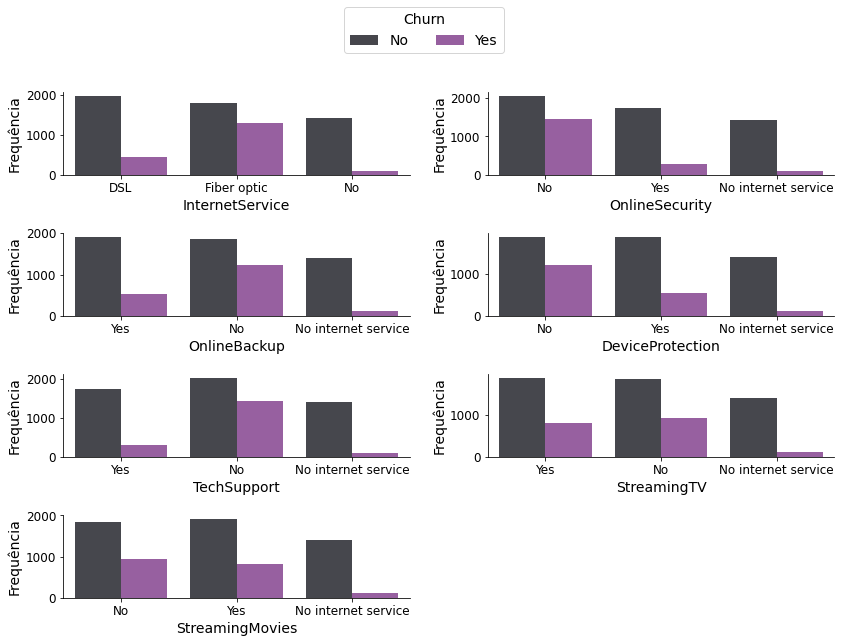

In [21]:
plot_countplots(dados_md2, 'Churn', grupo_3, figsize=(12, 8))

Muitos clientes mostraram hesitação em adotar cabos de fibra ótica como meio de fornecer serviços de Internet. Pelo contrário, de acordo com o primeiro gráfico, os clientes têm preferência por utilizar DSL para acessar a Internet. As categorias de Streaming de TV e Streaming de Filmes apresentam gráficos praticamente idênticos. Independentemente de estarem inscritos em Streaming de TV ou Streaming de Filmes, muitos clientes optaram por cancelar o serviço. Parece que o conteúdo de streaming não foi o único fator responsável por essa decisão.

No que diz respeito à satisfação dos clientes, fica evidente, a partir dos gráficos, que serviços como OnlineSecurity, OnlineBackup, DeviceProtection e TechSupport desempenham um papel fundamental. Um considerável quantidade de clientes que não possuiam essses serviços optaram deixar a empresa Novexus.

### Grupo 4: Features com assuntos financeiros dos clientes

In [22]:
grupo_4 = dados_md2.filter(like='account').columns.tolist()[:-2]

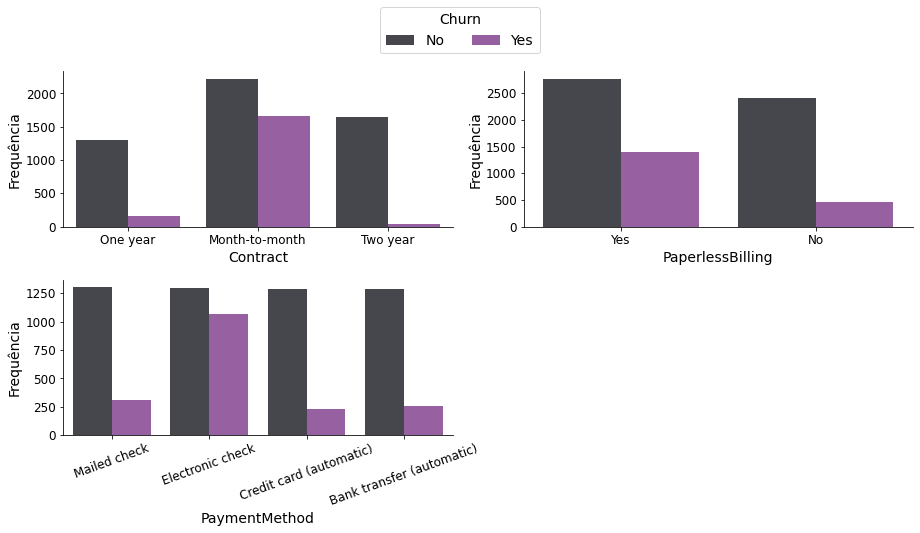

In [23]:
plot_countplots(dados_md2, 'Churn', grupo_4, figsize=(13, 6))
plt.xticks(rotation=20)
plt.show()

A alta taxa de rotatividade de clientes em contratos mensais pode ser atribuída a várias razões. Uma delas é a possibilidade de os clientes estarem experimentando diferentes serviços disponíveis, optando pelo contrato de um mês como uma forma de economizar dinheiro enquanto testam. Além disso, a inconsistência na qualidade dos serviços de Internet, streaming e telefone pode ser outro fator contribuinte. Como as prioridades dos clientes variam, se um desses serviços não atender às expectativas, muitas vezes resulta no cancelamento de todos os serviços.

Um fenômeno notável é a alta incidência de clientes de deixa a empresa no PaperlessBilling. Isso pode estar relacionado a problemas de pagamento ou recebimento que os clientes enfrentam. É evidente que os clientes não estão satisfeitos com o método de pagamento por cheque eletrônico. Portanto, a empresa claramente precisa reconsiderar o uso do cheque eletrônico como forma de pagamento, optando por simplificá-lo e torná-lo mais amigável para os clientes ou mesmo considerar a sua eliminação.

## Features numércias

In [24]:
features_num = dados_md2.select_dtypes(exclude=['object']).iloc[:, 1:]  # Excluindo o SeniorCitizen
features_num.head()

,customer.tenure,account.Charges.Monthly,account.Charges.Total
0,9,65.6,593.30
1,9,59.9,542.40
2,4,73.9,280.85
3,13,98.0,1237.85
4,3,83.9,267.40


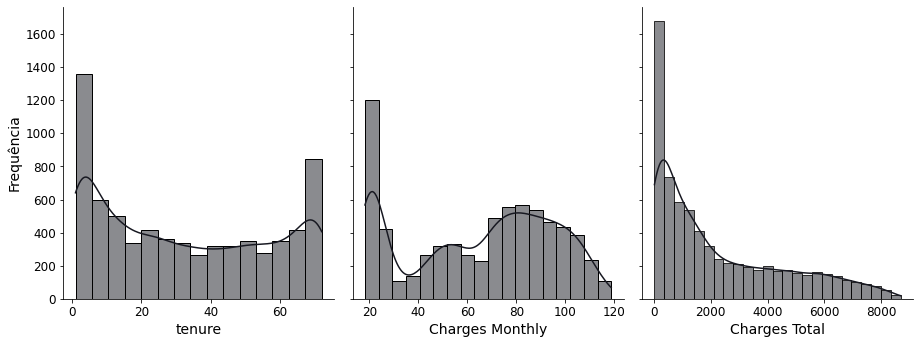

In [25]:
fig, axes = plt.subplots(1, len(features_num.columns), figsize=(13, 5), sharey = True)

for i, col in enumerate(features_num.columns):
    sns.histplot(dados_md2[col], ax=axes[i], color=paleta[0], kde=True)
    sns.despine(right=True, top=True)
    col_name = ' '.join(col.split('.')[1:])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequência')
        
plt.tight_layout()
plt.show()

Tenure e Charges Monthly possuem uma distribuição bimodal, apresentando picos notáveis em 0 e 70 para a Tenure e 20 e 80 para as Charges Monthly. Por outro lado, TotalCharges demonstra uma distribuição assimétrica positiva (caldas longas).

### Boxplot para as variáveis numéricas com Churn

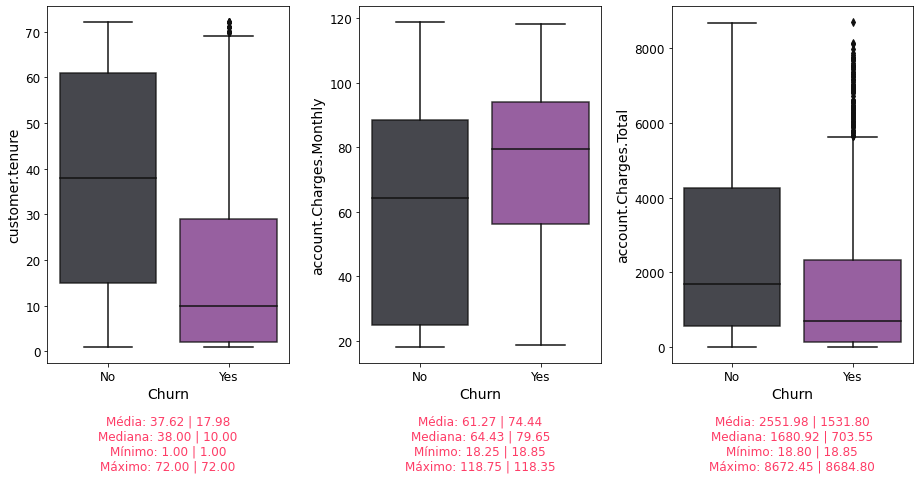

In [26]:
fig, axes = plt.subplots(1, len(features_num.columns), figsize=(13, 7))

for i, col in enumerate(features_num.columns):
    boxplot = sns.boxplot(x='Churn', y=col, data=dados_md2, ax=axes[i], palette=paleta) 
    
    for patch in boxplot.artists:
        patch.set_alpha(.8) 
        
    col_name = ' '.join(col.split('.')[1:])
    adicionar_estatisticas(axes[i], dados_md2, col, -0.3, paleta[-1])

plt.tight_layout()
plt.show()

Os clientes que optam por continuar têm, em média, contratos mais longos em comparação com aqueles que decidem cancelar. De forma surpreendente, os clientes que cancelaram seus contratos apresentam, em média, gastos mensais mais elevados do que os que permaneceram. Isso merece atenção, pois sugere a possibilidade de que clientes com despesas mais substanciais possam ser mais propensos a cancelar (talvez devido a variações nos tipos de serviços utilizados, como mencionado anteriormente). Além disso, é interessante observar que os clientes que cancelaram têm uma média de gastos totais mais baixa do que os que continuaram. Isso indica que, embora gastem mais em base mensal, essa tendência não se mantém a longo prazo, o que levanta a hipótese de que clientes com despesas mais elevadas não necessariamente representam maior valor a longo prazo para a empresa.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1> Análise da correlação das variáveis e Pré-processamento de dados prévio </h1>
</div>

A utilização da correlação pode aprimorar a acurácia do modelo ao eliminar variáveis preditoras sem relevância. Quando uma variável não demonstra uma correlação significativa com a variável-alvo, é provável que possua pouco poder informativo, não contribuindo de maneira substancial para o modelo e, em certos cenários, podendo até induzir overfitting.

O passo inicial consiste em lidar com as variáveis categóricas.

## Binarização dos dados categóricos

In [27]:
dados_md2.select_dtypes(exclude = ['int', 'float']).columns

Index(['customerID', 'Churn', 'customer.gender', 'customer.Partner',
       'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
       'internet.InternetService', 'internet.OnlineSecurity',
       'internet.OnlineBackup', 'internet.DeviceProtection',
       'internet.TechSupport', 'internet.StreamingTV',
       'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod'],
      dtype='object')

A coluna do ID do cliente não é relevante para nossos dados:

In [28]:
dados_md3 = dados_md2.drop('customerID', axis = 1).copy()

Vamos transformar as variáveis categóricas em valores binários:

In [29]:
def preprocessamento_binarizacao(df, colunas_sim_nao, colunas_multiclasses, colunas_mistas):
    df[colunas_sim_nao] = df[colunas_sim_nao].replace({'Yes': 1, 'No': 0})
    
    df['customer.gender'] = df['customer.gender'].replace({'Female': 1, 'Male': 0})

    df = pd.get_dummies(df, columns=colunas_multiclasses, dtype=int)

    # Função para criar colunas de serviço
    def criando_coluna_sem_servico(row):
        no_phone_service = 1 if 'No phone service' in row.values else 0
        no_internet_service = 1 if 'No internet service' in row.values else 0
        return pd.Series({'NoPhoneService': no_phone_service, 'NoInternetService': no_internet_service})

    colunas_sem_servico = df[colunas_mistas].apply(criando_coluna_sem_servico, axis=1)

    df[colunas_mistas] = df[colunas_mistas].replace({'Yes': 1, 'No': 0, 
                                                     'No internet service': 0, 'No phone service': 0})

    return pd.concat([df, colunas_sem_servico], axis=1)

colunas_sim_nao = ['Churn', 'customer.Partner', 'customer.Dependents', 
                   'phone.PhoneService', 'account.PaperlessBilling']

colunas_multiclasses = ['internet.InternetService', 'account.Contract', 
                        'account.PaymentMethod']

colunas_mistas = ['phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup', 
                  'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 
                  'internet.StreamingMovies']

dados_md4 = preprocessamento_binarizacao(dados_md3, colunas_sim_nao, 
                                         colunas_multiclasses, colunas_mistas).copy()

Por que optamos por realizar este procedimento em vez de utilizar o `get_dummies` diretamente? Queríamos manter o controle sobre os valores binários para "sim" e "não" diretamente.

Vamos olhar as colunas que indicam aparentemente a mesma coisa:

In [30]:
sem_servico_internet = ['internet.InternetService_No', 'NoInternetService']
set(list(dados_md4[sem_servico_internet].itertuples(index=False, name=None)))

{(0, 0), (1, 1)}

Ok. O que isso indica é que quando a coluna `internet.InternetService_No` possui o valor 0, a coluna `NoInternetService` também possui o valor 0, e o mesmo é verdadeiro no sentido oposto. Isso implica que ambas as colunas são equivalentes, portanto, podemos eliminar uma delas:

In [31]:
dados_md5 = dados_md4.drop(columns = sem_servico_internet[0]).copy()

Vejamos o caso para o serviço de telefonia:

In [32]:
sem_servico_telefone = ['phone.PhoneService', 'NoPhoneService']
set(list(dados_md4[sem_servico_telefone].itertuples(index=False, name=None)))

{(0, 1), (1, 0)}

Na verdade, a situação aqui é inversa: quando uma delas possui o valor 0, a outra terá o valor 1, e vice-versa. Para entender, a coluna `phone.PhoneService` indica se o serviço está disponível (1) ou não (0), enquanto a coluna `NoPhoneService` indica se o serviço não está disponível (1) ou está disponível (0). Portanto, essas duas colunas são complementares, e é possível remover uma delas sem perda de informação:

In [33]:
dados_md6 = dados_md5.drop(columns = sem_servico_telefone[0]).copy()

## Correlação features com a target

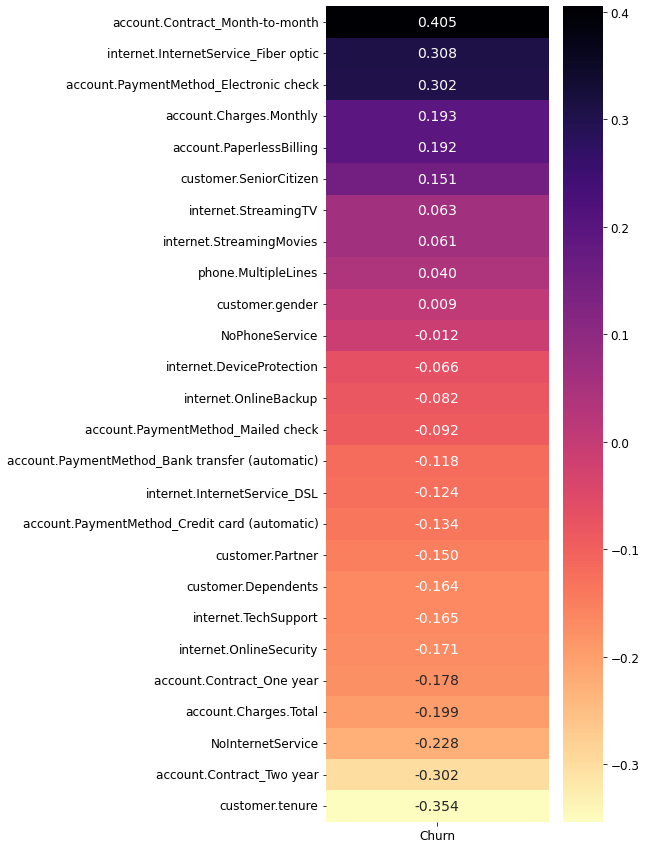

In [34]:
corr = dados_md6.corrwith(dados_md6['Churn']).sort_values(ascending = False).to_frame().iloc[1:,:]
corr.columns = ['Churn']

plt.figure(figsize=(5, 15))
sns.heatmap(corr, annot = True, cmap = 'magma_r', fmt = '.3f')
plt.show()

- A coluna `Churn` foi removida, pois possui uma correlação de 1 consigo mesma, o que é evidente, uma vez que é a mesma variável.

- A correlação mais forte e positiva é com o contrato mensal. Isso indica que os clientes que possuem contratos mensais têm uma probabilidade significativamente maior de cancelar seus serviços em comparação com aqueles que têm contratos anuais ou bienais.

- Os clientes que utilizam o serviço de fibra ótica também apresentam uma correlação positiva, sugerindo que eles são mais propensos a cancelar em comparação com os clientes que utilizam outros tipos de conexão à Internet. Isso também se aplica ao pagamento eletrônico.

- Embora a correlação seja positiva para as despesas mensais, sua força é menor em comparação com as três primeiras variáveis. Isso sugere que clientes com mensalidades mais altas podem ter uma probabilidade ligeiramente maior de cancelar, mas essa relação não é tão marcante quanto outros fatores.

- A variável `customer.tenure` apresenta a correlação negativa mais forte. Quanto mais tempo um cliente permanece com a empresa, menor é a probabilidade de cancelamento. Isso também é coerente quando observamos a segunda variável mais negativa.

- A correlação negativa com a variável `NoInternetService` sugere que os clientes que não têm serviço de Internet são menos propensos a cancelar.

- Os clientes com dependentes também exibem uma correlação negativa, indicando que são menos propensos a cancelar em comparação com aqueles sem dependentes.

Resumidamente, fatores como a duração do contrato, a presença de serviços adicionais (como segurança na Internet e suporte técnico), métodos de pagamento eletrônico e a utilização de fibra ótica podem desempenhar um papel fundamental na retenção de clientes.

Pronto, nosso dados estão analisados e limpos o suficientes, podemos salvar o novo dataframe e seguir para o próximo passo!

In [35]:
dados_md6.to_csv('Dados/dados_novexus_tratado.csv', index = False)